In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
from sklearn import preprocessing
from keras.layers.core import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from keras.models import Sequential
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("drive/MyDrive/ambient_temperature_system_failure.csv")

In [4]:
print(df)

                timestamp      value
0     2013-07-04 00:00:00  69.880835
1     2013-07-04 01:00:00  71.220227
2     2013-07-04 02:00:00  70.877805
3     2013-07-04 03:00:00  68.959400
4     2013-07-04 04:00:00  69.283551
...                   ...        ...
7262  2014-05-28 11:00:00  72.370206
7263  2014-05-28 12:00:00  72.172956
7264  2014-05-28 13:00:00  72.046565
7265  2014-05-28 14:00:00  71.825226
7266  2014-05-28 15:00:00  72.584089

[7267 rows x 2 columns]


In [5]:
df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


In [6]:
df.value

0       69.880835
1       71.220227
2       70.877805
3       68.959400
4       69.283551
          ...    
7262    72.370206
7263    72.172956
7264    72.046565
7265    71.825226
7266    72.584089
Name: value, Length: 7267, dtype: float64

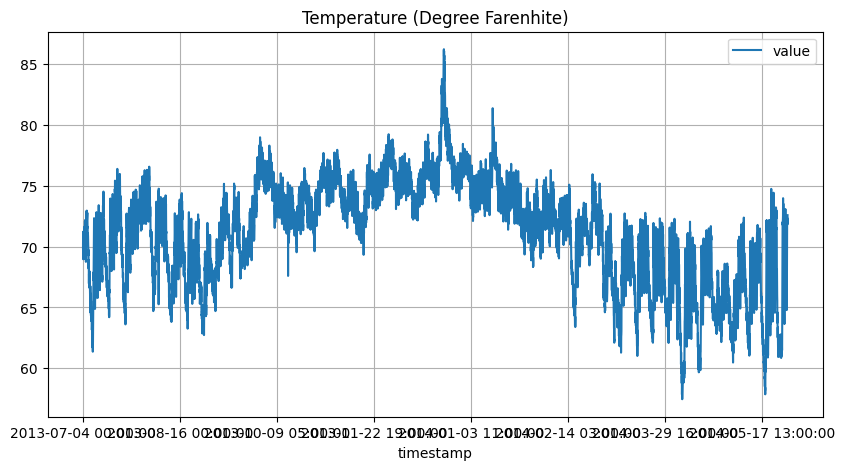

In [7]:
figsize=(10,5)
df.plot(x='timestamp', y='value', figsize=figsize, title='Temperature (Degree Farenhite)');
plt.grid();
plt.show();

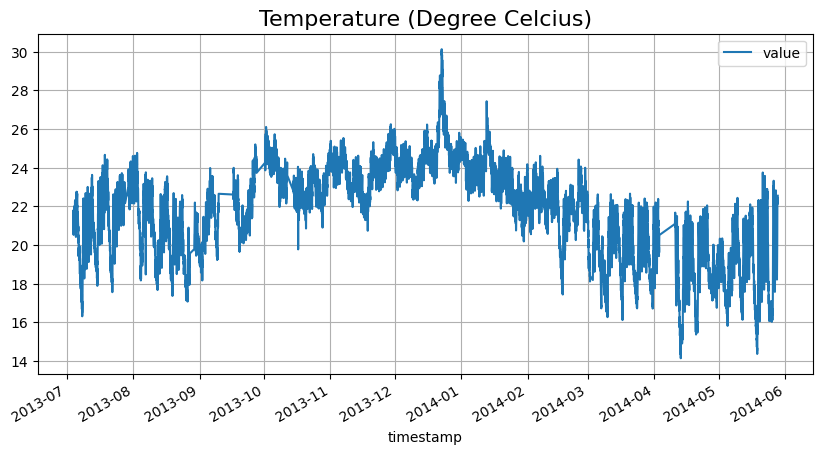

In [8]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['value'] = (df['value'] - 32) * 5/9
df.plot(x='timestamp', y='value', figsize=figsize);
plt.title('Temperature (Degree Celcius)', fontsize=16);
plt.grid();
plt.show();

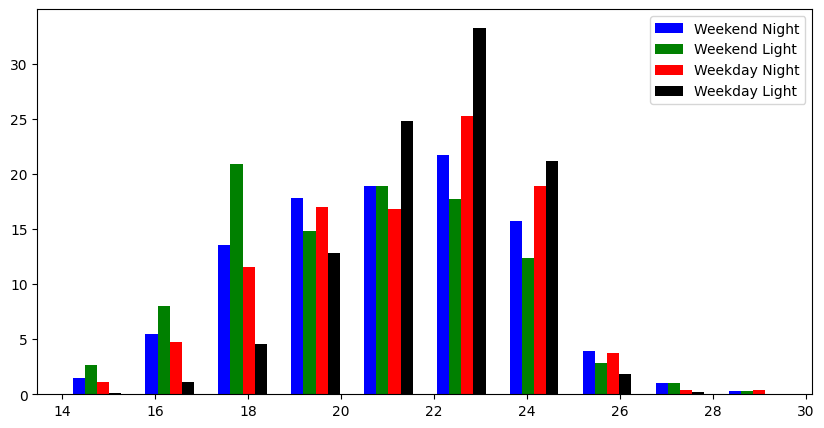

In [9]:
#Formating the data into required format
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)

# Anomaly estimated population
outliers_fraction = 0.01

df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

df['categories'] = df['WeekDay']*2 + df['daylight']
a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

#Visualizing the formatted data
figsize=(10,5)
fig, ax = plt.subplots(figsize=figsize)
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)
width = (a_bins[1] - a_bins[0])/6
ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='Weekend Night')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='Weekend Light')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='Weekday Night')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='Weekday Light')
plt.legend()
plt.show()

In [10]:
data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

In [11]:
#Important parameters and training/Test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#Training data
x_train = data_n[0:-prediction_time-testdatacut].values
y_train = data_n[prediction_time:-testdatacut  ][0].values

#Test data
x_test = data_n[0-testdatacut:-prediction_time].values
y_test = data_n[prediction_time-testdatacut:  ][0].values

In [12]:
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

#Adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

In [13]:
#Shape of the data
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6165, 50, 5)
y_train (6165,)
x_test (1000, 50, 5)
y_test (1000,)


In [14]:
#Building the model
model = Sequential()

model.add(LSTM(input_dim=x_train.shape[-1], units=50, return_sequences=True))
model.add(Dropout(0.2))


model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.012090444564819336


In [15]:
t=model.fit(x_train, y_train, batch_size=3028, epochs=50, validation_split=0.1)

Epoch 1/50
2/2 [==============================] - 12s 3s/step - loss: 0.6844 - val_loss: 0.8517
Epoch 2/50
2/2 [==============================] - 5s 3s/step - loss: 0.2637 - val_loss: 0.4776
Epoch 3/50
2/2 [==============================] - 5s 2s/step - loss: 0.1613 - val_loss: 0.4283
Epoch 4/50
2/2 [==============================] - 4s 2s/step - loss: 0.1590 - val_loss: 0.2939
Epoch 5/50
2/2 [==============================] - 5s 3s/step - loss: 0.1125 - val_loss: 0.2663
Epoch 6/50
2/2 [==============================] - 5s 2s/step - loss: 0.1107 - val_loss: 0.2578
Epoch 7/50
2/2 [==============================] - 4s 2s/step - loss: 0.1141 - val_loss: 0.2291
Epoch 8/50
2/2 [==============================] - 5s 3s/step - loss: 0.1000 - val_loss: 0.2166
Epoch 9/50
2/2 [==============================] - 5s 2s/step - loss: 0.0938 - val_loss: 0.2124
Epoch 10/50
2/2 [==============================] - 4s 2s/step - loss: 0.0934 - val_loss: 0.2129
Epoch 11/50
2/2 [==============================]

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 50)          11200     
                                                                 
 dropout (Dropout)           (None, None, 50)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 71,701
Trainable params: 71,701
Non-traina

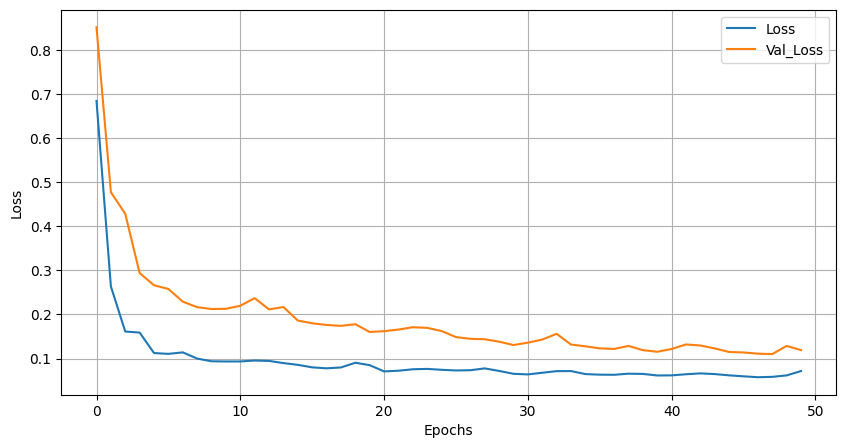

In [17]:
plt.figure(figsize = (10, 5))
plt.plot(model.history.history['loss'], label = 'Loss')
plt.plot(model.history.history['val_loss'], label = 'Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

32/32 [==============================] - 1s 21ms/step


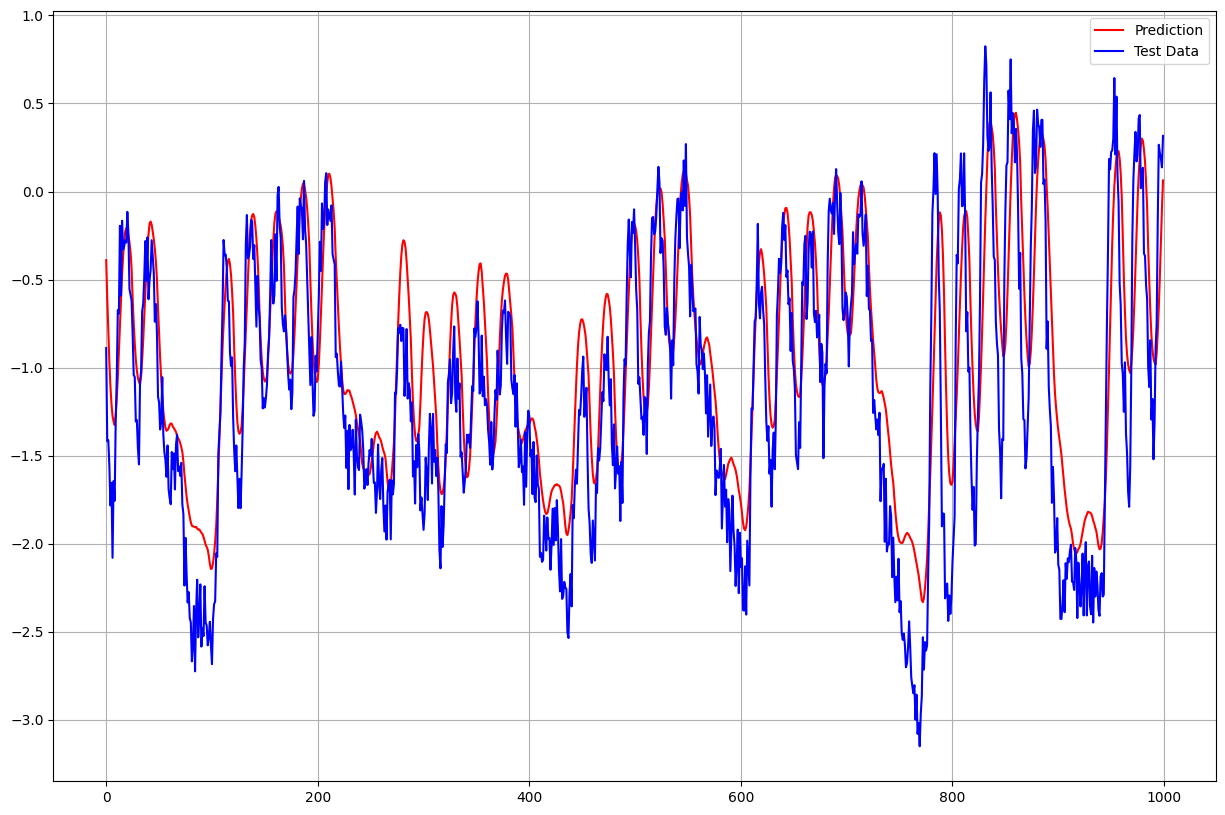

In [18]:
#creating the list of difference between prediction and test data
loaded_model = model
diff=[]
ratio=[]
p = loaded_model.predict(x_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

#Plotting the prediction and the reality (for the test data)
plt.figure(figsize = (15, 10))
plt.plot(p,color='red', label='Prediction')
plt.plot(y_test,color='blue', label='Test Data')
plt.legend(loc='upper left')
plt.grid()
plt.legend()

0    7257
1      10
Name: anomaly27, dtype: int64


<ipython-input-19-c57297c5317f>:8: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df['anomaly27'] = complement.append(test, ignore_index='True')


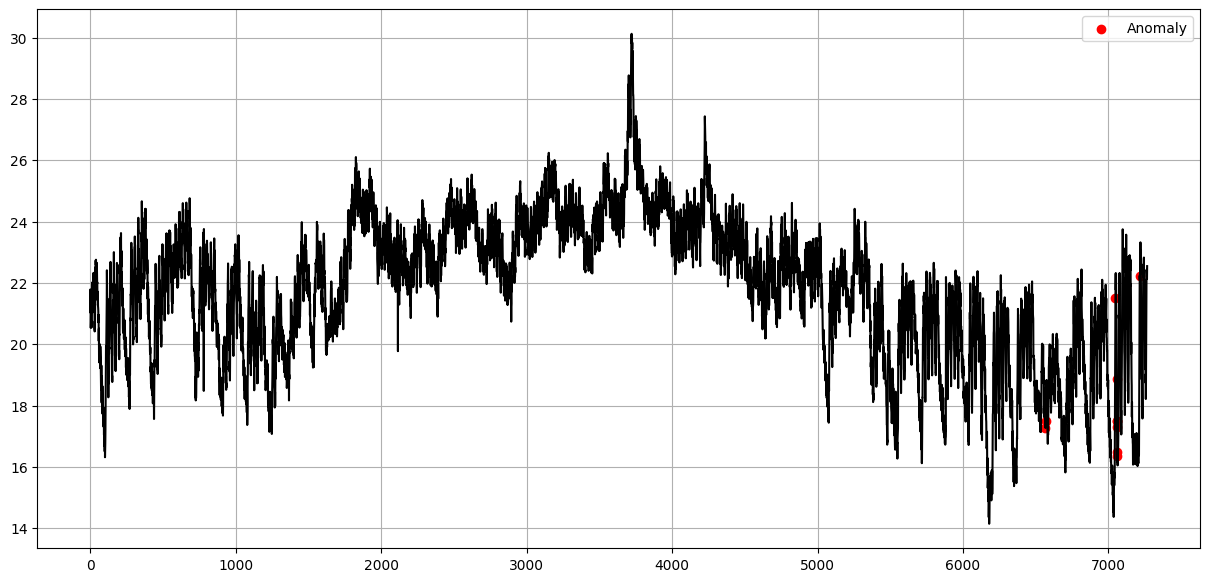

In [19]:
#Pick the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
#Data with anomaly label
test = (diff >= threshold).astype(int)
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
df['anomaly27'] = complement.append(test, ignore_index='True')
print(df['anomaly27'].value_counts())
#Finally, we will visualize the anomalies using the below code for plotting. 

#Visualizing anomalies (Red Dots)
plt.figure(figsize=(15,7))
a = df.loc[df['anomaly27'] == 1, ['time_epoch', 'value']] #anomaly
plt.plot(df.index, df['value'], color='black')
plt.scatter(a.index,a['value'], color='red', label = 'Anomaly')
# plt.axis([1.40*1e7, 1.402*1e7, 15,24])
plt.grid()
plt.legend()